This notebook applies an inverted Transformer model using PyTorch & Lightning, to get multi-step quantile energy consumption forecasts. 
\
It also performs the necessary data handling & preprocessing steps to get source & target sequences for the Transformer model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightning as L
import optuna
import warnings

from lightning.pytorch.callbacks import Callback
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, root_mean_squared_log_error as rmsle, mean_pinball_loss as pinball

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 1923

In [3]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
L.seed_everything(random_seed, workers = True)
warnings.filterwarnings("ignore", ".*does not have many workers.*")

Seed set to 1923


In [4]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [5]:
output_dir = "./OutputData/"

In [6]:
df = pd.read_csv(output_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])

In [7]:
df

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,24635.32,27412.81,2,7.071068e-01,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23872.12,26324.39,3,8.660254e-01,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23194.89,24635.32,4,9.659258e-01,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23071.96,23872.12,5,1.000000e+00,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23267.90,23194.89,6,9.659258e-01,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52577,2023-12-31 19:00:00,35090.93,34549.42,52579,-8.660254e-01,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,33310.94,36193.59,52580,-7.071068e-01,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,32083.96,35090.93,52581,-5.000000e-01,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52580,2023-12-31 22:00:00,30469.49,33310.94,52582,-2.588190e-01,9.659258e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


## Data prep: Getting input & output sequences

We will create a "shifted dataset" where each row at time T contains the following columns:
- Target value at T (consumption lead T+1),
- Past value at T (consumption lag T-2),
- Time covariates at T.

In [8]:
# Get shifted dataset, drop last row due to unknown target
df_shifted = df.copy()
df_shifted["consumption_MWh"] = df_shifted.consumption_MWh.shift(-1)
df_shifted = df_shifted.dropna()

In [9]:
df_shifted

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,23872.12,27412.81,2,0.707107,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23194.89,26324.39,3,0.866025,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23071.96,24635.32,4,0.965926,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23267.90,23872.12,5,1.000000,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23875.44,23194.89,6,0.965926,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52576,2023-12-31 18:00:00,35090.93,32670.06,52578,-0.965926,2.588190e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52577,2023-12-31 19:00:00,33310.94,34549.42,52579,-0.866025,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,32083.96,36193.59,52580,-0.707107,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,30469.49,35090.93,52581,-0.500000,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


Every source sequence will be the last 72 hours before 16:00, and every target sequence will be the next 32 hours after 16:00.

In [10]:
# Set fixed parameters
n_steps = len(df_shifted) 
source_length = 72 # T-L to T hours
source_dims = 8 # Consumption lag 2, trend, 6 cyclical columns as features
target_length = 32 # We are only interested in predicting T+8 to 32, but we'll make this a model parameter
horizon_start = 0 # Output step to start loss calculation from
quantiles = [0.025, 0.5, 0.975] # Quantiles to predict

In [11]:
# Find the index of the first 16:00 row in the data, where the index is bigger than source_length - 1. This will be the first T.
first_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index >= source_length - 1)].index.values[0]

In [12]:
first_t 

86

In [13]:
# Find the index of the last 16:00 row in the data, with 32 time steps after it. This will be the last T.
last_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index + target_length - 1 <= df.index.values[-1])].index.values[-2]

In [14]:
last_t 

52526

Each source sequence will contain the following:
- Consumption lag 2 at [T - source_length, T] (past targets),
- Time covariates at [T - source_length, T] (past covariates).

In [15]:
# One source sequence
source_seq = pd.concat([
    df_shifted.iloc[(first_t - source_length):first_t, 0], # Time
    df_shifted.iloc[(first_t - source_length):first_t, 2], # Past target
    df_shifted.iloc[(first_t - source_length):(first_t), 3:] # Past covariates
], axis = 1)

Each output sequence will contain the following:
- Consumption at [T+1, T + output_length] (future targets),
- Time covariates at [T+1, T + output_length] (future known covariates)

In [16]:
# One output sequence
target_seq = pd.concat([
    df_shifted.iloc[first_t:(first_t + target_length), 0], # Time 
    df_shifted.iloc[first_t:(first_t + target_length), 1], # Future target
    df_shifted.iloc[first_t:(first_t + target_length), 3:] # Future known covariates
], axis = 1)

In [17]:
source_seq.iloc[-5:]

,time,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39641.36,83,1.224647e-16,-1.000000,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,40593.83,84,-2.588190e-01,-0.965926,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,40955.07,85,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39505.55,86,-7.071068e-01,-0.707107,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,39635.29,87,-8.660254e-01,-0.500000,-0.433884,-0.900969,0.5,0.866025


In [18]:
target_seq[:5]

,time,consumption_MWh,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
86,2018-01-04 16:00:00,40487.65,88,-0.965926,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,89,-1.000000,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,90,-0.965926,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,91,-0.866025,5.000000e-01,-0.433884,-0.900969,0.5,0.866025
90,2018-01-04 20:00:00,36758.94,92,-0.707107,7.071068e-01,-0.433884,-0.900969,0.5,0.866025


In [19]:
df_shifted.iloc[81:90]

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39505.55,39641.36,83,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,39635.29,40593.83,84,-2.588190e-01,-9.659258e-01,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,39952.75,40955.07,85,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39649.45,39505.55,86,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,40063.17,39635.29,87,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.5,0.866025
86,2018-01-04 16:00:00,40487.65,39952.75,88,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,39649.45,89,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,40063.17,90,-9.659258e-01,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,40487.65,91,-8.660254e-01,5.000000e-01,-0.433884,-0.900969,0.5,0.866025


In the source sequence, we pair every past target value at T with the past covariates at T.
\
In the output sequence, we pair every future target value at T+1 with the future covariates at T+1.
\
This is more straightforward than the LSTM sequencing in notebook 3.1, because we will make our predictions in one go, and don't need to combine predictions at T+1 with future covariates at T+2 to get the input sequence for T+1. 
\
We will simply initialize the future targets from T+1 onwards as a linear extrapolation of the past targets from T - source_length to T. We'll do this in training as well as validation & prediction. 
\
The idea is that the model should learn to "enrich" a simple linear extrapolation given additional future known covariates.

In [20]:
n_sequences = (last_t - first_t) // 24 + 1 # Number of 16:00 rows followed by a sufficient length source / target sequence
print("Number of possible sequences: " + f"{n_sequences}")

Number of possible sequences: 2186


In [21]:
# Get all sequences
for t in range(first_t, last_t + 1, 24):

    # Get source sequence
    new_source = pd.concat([
        df_shifted.iloc[(t - source_length):t, 0], # Time
        df_shifted.iloc[(t - source_length):t, 2], # Past target
        df_shifted.iloc[(t - source_length):t, 3:] # Past covariates
        ], axis = 1)
    new_source = new_source.set_index("time")

    # Get target sequence
    new_target = pd.concat([
        df_shifted.iloc[t:(t + target_length), 0], # Time 
        df_shifted.iloc[t:(t + target_length), 1], # Future target
        df_shifted.iloc[t:(t + target_length), 3:] # Future known covariates
        ], axis = 1)
    new_target = new_target.set_index("time")

    if t == first_t:

        # Initialize lists of sequences
        source_sequences = [new_source]
        target_sequences = [new_target]
        
    else:
        # Concatenate to arrays of sequences
        source_sequences.append(new_source)
        target_sequences.append(new_target)


In [22]:
len(source_sequences)

2186

In [23]:
len(target_sequences)

2186

## Preprocessing: Custom scaler, Torch datasets & dataloaders

In [24]:
# Get indices for train - val - test split
sixty_percent = int(len(source_sequences) * 0.6)
twenty_percent = int(len(target_sequences) * 0.2)
train_end = sixty_percent
val_end = sixty_percent + twenty_percent

We'll keep batch sizes constant to match the evaluation scheme with the stateful LSTM in notebook 3.1, though there should be no need with this model. 
\
We'll divide the lengths of each data fold with the batch size, drop the remainder from the start of the training folds & the end of the val. & test folds.

In [25]:
# Perform train - val - test split
batch_size = 64

# Training data at validation step
tr_source, tr_target = source_sequences[0:train_end], target_sequences[0:train_end]
remainder = len(tr_source) % batch_size
tr_source, tr_target = tr_source[remainder:], tr_target[remainder:]

# Training data at testing step
train_source, train_target = source_sequences[0:val_end], target_sequences[0:val_end]
remainder = len(train_source) % batch_size
train_source, train_target = train_source[remainder:], train_target[remainder:]

# Validation data
val_source, val_target = source_sequences[train_end:val_end], target_sequences[train_end:val_end]
remainder = len(val_source) % batch_size
val_source, val_target = val_source[:-remainder], val_target[:-remainder]

# Testing data
test_source, test_target = source_sequences[val_end:], target_sequences[val_end:]
remainder = len(test_source) % batch_size
test_source, test_target = test_source[:-remainder], test_target[:-remainder]

In [26]:
test_source[0]

,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
time,,,,,,,,
2022-10-15 16:00:00,36626.13,41968,-9.659258e-01,-2.588190e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 17:00:00,35781.60,41969,-1.000000e+00,-1.836970e-16,-0.781831,0.623490,-0.866025,0.5
2022-10-15 18:00:00,35326.54,41970,-9.659258e-01,2.588190e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 19:00:00,35455.95,41971,-8.660254e-01,5.000000e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 20:00:00,36296.82,41972,-7.071068e-01,7.071068e-01,-0.781831,0.623490,-0.866025,0.5
...,...,...,...,...,...,...,...,...
2022-10-18 11:00:00,38067.75,42035,1.224647e-16,-1.000000e+00,0.974928,-0.222521,-0.866025,0.5
2022-10-18 12:00:00,38820.67,42036,-2.588190e-01,-9.659258e-01,0.974928,-0.222521,-0.866025,0.5
2022-10-18 13:00:00,39206.44,42037,-5.000000e-01,-8.660254e-01,0.974928,-0.222521,-0.866025,0.5


In [27]:
# First prediction point in testing data
test_target[0].index[0]

Timestamp('2022-10-18 16:00:00')

We have to scale the past consumption values in the source sequences, and covariates in both source & target sequences. 
\
We also need to scale the real target consumption values because they are used in the loss calculation, even if not passed as input to the model.
\
We also need the ability to backtransform the network's final predictions accordingly.

In [28]:
# Define scaling class for sequence data
class sequence_scaler:
    """
    Takes in lists of dataframes where each dataframe is a source or target sequence.

    Returns scaled 3D numpy arrays of shape (observations, timesteps, features).
    Can also backtransform scaled predictions.
    """

    def __init__(self, feature_range = (-1, 1)):
        self.lower = feature_range[0]
        self.upper = feature_range[1]

    def fit(self, source_df, target_df):

        # Get source & target sequences as 3D arrays
        # The time index will be skipped, yielding shape (N, seq_length, seq_dims)
        source = np.stack(source_df, axis = 0)
        target = np.stack(target_df, axis = 0)

        # Get number of dimensions
        self.num_dimensions = source.shape[2]
        
        # Extract & save minimum, maximum for each dimension
        dimensions_mini = []
        dimensions_maxi = []
        for dimension in range(0, self.num_dimensions):
            min = np.min([
                np.min(source[:, :, dimension]),
                np.min(target[:, :, dimension])
            ])
            dimensions_mini.append(min)

            max = np.max([
                np.max(source[:, :, dimension]),
                np.max(target[:, :, dimension])
            ])
            dimensions_maxi.append(max)

        self.dimensions_mini = dimensions_mini
        self.dimensions_maxi = dimensions_maxi

    def transform(self, scale_df):

        # Get sequence as 3D arrays
        scale_array = np.stack(scale_df, axis = 0)

        # Initialize list of scaled dimensions
        scaled_dimensions = []

        # Scale each dimension & append to list
        for dimension in range(0, self.num_dimensions):
            values = scale_array[:, :, dimension]
            min = self.dimensions_mini[dimension]
            max = self.dimensions_maxi[dimension]
            std = (values - min) / (max - min)
            scaled = std * (self.upper - self.lower) + self.lower
            scaled_dimensions.append(scaled)

        # Stack over 3rd axis & return
        return np.stack(scaled_dimensions, axis = 2)

    def backtransform_preds(self, preds_array, fitted_preds_dim = 0):

        # Get n. of predicted quantiles to backtransform
        n_quantiles = preds_array.shape[-1]

        # Get the fitted mini & maxi for predictions
        min = self.dimensions_mini[fitted_preds_dim] 
        max = self.dimensions_maxi[fitted_preds_dim]

        # Initialize list of backtransformed quantiles
        backtrafo_quantiles = []

        # Backtransform each quantile & append to list
        for quantile in range(0, n_quantiles):
            scaled = preds_array[:, :, quantile]
            std = (scaled - self.lower) / (self.upper - self.lower)
            values = std * (max - min) + min
            backtrafo_quantiles.append(values)
            
        # Stack over 3rd axis & return
        return np.stack(backtrafo_quantiles, axis = 2)

We can use one Torch dataset class both for training & validation (known future targets part of passed target sequences), and for prediction (no known future targets in the target sequences).
\
In the former case, both the source & target sequence need to have D feature dimensions (including targets). In the latter case, the target sequence needs to have D-1 feature dimensions, without targets.

In [29]:
# Define Torch dataset class
class SequenceDataset(torch.utils.data.Dataset):
    """
    Simply takes in the input & output sequences as 3D arrays and returns them as Torch tensors.
    """

    # Store preprocessed source & target sequences
    def __init__(self, source_seq, target_seq): 
        self.source_seq = torch.tensor(source_seq, dtype = torch.float32) # Store input sequences
        self.target_seq = torch.tensor(target_seq, dtype = torch.float32) # Store output sequences
  
    # Return data length  
    def __len__(self):
        return len(self.source_seq) 
  
    # Return a pair of input & output sequences
    def __getitem__(self, idx):
        return self.source_seq[idx], self.target_seq[idx]

In [30]:
# Scale validation data & create Torch datasets
scaler_val = sequence_scaler()
_ = scaler_val.fit(tr_source, tr_target)
tr_data = SequenceDataset(scaler_val.transform(tr_source), scaler_val.transform(tr_target))
val_data = SequenceDataset(scaler_val.transform(val_source), scaler_val.transform(val_target))

# Scale testing data & create Torch datasets. Index out the target values for the testing target sequences
scaler_test = sequence_scaler()
_ = scaler_test.fit(train_source, train_target)
train_data = SequenceDataset(scaler_test.transform(train_source), scaler_test.transform(train_target))
test_data = SequenceDataset(scaler_test.transform(test_source), scaler_test.transform(test_target)[:, :, 1:])

In [31]:
# Create Torch dataloaders
num_workers = 0
shuffle = False

# Training data at validation step
tr_loader = torch.utils.data.DataLoader(
    tr_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Training data at testing step
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Validation & testing data
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

## Model definition

In [32]:
# Define QuantileLoss, because pytorch_forecasting installation raises issues with Python 3.12
class QuantileLoss:
    """
    Takes in targets of shape (...),
    predictions of shape (..., n_quantiles),
    quantiles list.
    
    Returns unreduced quantile loss tensor of shape (..., n_quantiles),
    where each value is quantile loss * 2 (equal to the MAE for q = 0.5).
    
    Implemented from pytorch_forecasting.metrics.quantile.QuantileLoss.
    """

    def __init__(self, quantiles):
        self.quantiles = quantiles

    def loss(self, pred, target):
        
        quantile_losses = []
        for i, q in enumerate(self.quantiles):
            error = target - pred[..., i]
            quantile_error = torch.max(
                (q - 1) * error,
                q * error
            ).unsqueeze(-1)
            quantile_losses.append(quantile_error)

        quantile_losses = torch.cat(quantile_losses, dim = 2)
        return quantile_losses

In [35]:
# Define model class
class LITransformer(L.LightningModule):
    """
    Transformer architecture which takes in inverted sequences of shape (batch_size, features, timesteps) as input.
    
    In both training & inference, the past target values from the source sequence are linearly extrapolated to initialize 
    the target values in the target sequence.
    
    The source sequence consists of past target & covariate values, and is fed to the encoder.
    The target sequence consists of the linear trend prediction & covariate values, and is fed to the decoder.
    No causal masking is applied, as true target values are not fed to the model.
    
    The model outputs quantile predictions.
    """

    # Initialize model
    def __init__(self, hyperparams_dict):
        
        # Delegate function to parent class
        super().__init__() 
        
        # Save external hyperparameters so they are available when loading saved models
        self.save_hyperparameters(logger = False) 

        # Define hyperparameters
        self.source_length = hyperparams_dict["source_length"] # Length of source sequence, L
        self.target_length = hyperparams_dict["target_length"] # Length of target sequence, H
        self.horizon_start = hyperparams_dict["horizon_start"] # Start of the forecast horizon relevant for loss computing
        self.quantiles = hyperparams_dict["quantiles"] # Provide as list of floats: [0.025, 0.5, 0.975]
        self.d_model = hyperparams_dict["d_model"] # Dimensionality of attention inputs, d
        self.n_heads = hyperparams_dict["n_heads"] # N. of attention heads per multiattention block
        self.n_encoders = hyperparams_dict["n_encoders"] # N. of encoder blocks
        self.n_decoders = hyperparams_dict["n_decoders"] # N. of decoder blocks
        self.d_feedforward = hyperparams_dict["d_feedforward"] # Dimensionality of feedforward networks
        self.activation = hyperparams_dict["activation"] # Activation function for transformer FFNs
        self.learning_rate = hyperparams_dict["learning_rate"]
        self.lr_decay = hyperparams_dict["lr_decay"]
        self.dropout_rate = hyperparams_dict["dropout_rate"]

        # Define loss function: Quantile loss
        self.loss = QuantileLoss(quantiles = self.quantiles)
        self.n_quantiles = len(self.quantiles) # Number of quantiles, Q

        # Define architecture components

        # Source projection, input shape (N, D, L), output shape (N, D, d)
        self.source_project = torch.nn.Linear(
            in_features = self.source_length,
            out_features = self.d_model
        )

        # Target projection, input shape (N, D, H), output shape (N, D, d)
        self.target_project = torch.nn.Linear(
            in_features = self.target_length,
            out_features = self.d_model
        )

        # Dropout layer for projections
        self.dropout = torch.nn.Dropout(p = self.dropout_rate)

        # Transformer, input shapes (N, D, d), output shape (N, D, d)
        self.transformer = torch.nn.Transformer(
            d_model = self.d_model,
            nhead = self.n_heads,
            num_encoder_layers = self.n_encoders,
            num_decoder_layers = self.n_decoders,
            dim_feedforward = self.d_feedforward,
            dropout = self.dropout_rate,
            activation = self.activation,
            batch_first = True
        )
        
        # Output layer, input shape (N, D, d), output shape (N, D, H * Q)
        # The output is flattened across timesteps & quantiles, needs to be 
        # indexed & reshaped into shape (N, H, Q) 
        self.output_layer = torch.nn.Linear(
            in_features = self.d_model,
            out_features = self.target_length * self.n_quantiles
        )

    # Define linear trend extrapolation method
    # Input: Past targets(N, L) 
    # Output: Linearly extrapolated future targets(N, H)
    def linear_trend(self, past_target):

        # Get batch size
        batch_size = past_target.shape[0]

        # Get timestep index vectors
        past_idx = torch.arange(0, self.source_length).float()
        future_idx = torch.arange(
            self.source_length, 
            (self.source_length + self.target_length)).float()

        # Get vectors & matrices for linear extrapolation
        ones = torch.ones(self.source_length)
        x = torch.stack((past_idx, ones), 1).to("cpu")
        x_t = torch.transpose(x, 0, 1).to("cpu")
        y = past_target.unsqueeze(-1).to("cpu") 
        
        # Estimate linear extrapolation parameters for each batch
        params = torch.matmul(
            torch.matmul(x_t, y).squeeze(-1), torch.linalg.inv(torch.matmul(x_t, x))
        )
        slopes = params[:, 0]
        constants = params[:, 1]

        # Extrapolate trend to future for each batch
        future_target = future_idx.repeat(batch_size, 1) * slopes.unsqueeze(-1) + constants.unsqueeze(-1)
        return future_target.to(self.device)

    # Define forward propagation
    def forward(self, source_seq, target_seq):

        # Project source & target sequences
        # Inputs: Inverted source(N, D, L) and target(N, D, H) sequences
        source = self.dropout(self.source_project(source_seq))
        target = self.dropout(self.target_project(target_seq))

        # Pass source & target sequences to transformer
        # Causal masking is disabled for the target sequence, as the passed values are predictions
        # Inputs: Projected source and target sequences, (N, D, d)
        transformer_output = self.transformer(
            source, target,
            src_is_causal = False,
            tgt_is_causal = False
        )

        # Pass transformer outputs to output layer, with residual connection to pre-transformer target sequence
        # Input: Transformer output(N, D, d)
        output = self.output_layer(target + transformer_output)

        # Output: Flattened quantile predictions(N, D, H * Q)
        return output

    # Define training step
    # Assumes both source & target sequences are passed to SequenceDataset with D dimensions, target values included
    def training_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D)
        source_seq, target_seq = batch
        
        # Cast aside real future targets for loss calculation
        real_future_target = target_seq[:, :, 0] # Shape (N, H)
        target_seq = target_seq[:, :, 1:] # Shape (N, H, D-1)

        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        # BRAVO NOLAN
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)

        # Calculate loss, starting from the chosen future time step  
        loss = self.loss.loss(
            preds[:, self.horizon_start:, :], 
            real_future_target[:, self.horizon_start:]
        ) # Shape (N, H - horizon_start, Q)

        # Reduce the quantile loss
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Shape (N, H - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Shape (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss for backpropagation.

        # Log the train loss
        self.log("train_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

        return loss_reduced
    
    # Define validation_step
    # Assumes both source & target sequences are passed to SequenceDataset with D dimensions, target values included
    def validation_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D)
        source_seq, target_seq = batch
        
        # Cast aside real future targets for loss calculation
        real_future_target = target_seq[:, :, 0] # Shape (N, H)
        target_seq = target_seq[:, :, 1:] # Shape (N, H, D-1)

        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)

        # Calculate loss, starting from the chosen future time step  
        loss = self.loss.loss(
            preds[:, self.horizon_start:, :], 
            real_future_target[:, self.horizon_start:]
        ) # Shape (N, H - horizon_start, Q)

        # Reduce the quantile loss
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Shape (N, H - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Shape (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss.

        # Log the validation loss
        self.log("val_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

    # Define prediction_step
    # Assumes target sequences are passed to SequenceDataset with D-1 dimensions, target values excluded
    def predict_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D-1)
        source_seq, target_seq = batch
        
        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)
        return preds

    # Define optimizer & learning rate scheduler
    def configure_optimizers(self):

        # Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        
        # Exponential LR scheduler
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
          optimizer, gamma = self.lr_decay) 
        
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
          "scheduler": lr_scheduler
          }
        }

## Hyperparameter tuning with Optuna

In [34]:
# Define tuning parameters
tol = 0.002 # Change in MAE to avoid early stopping
patience = 5 # N. of rounds with no improvement before early stopping

In [36]:
# Define Optuna objective
def objective_transformer(trial):

    # Define search space
    d_model = 2 ** trial.suggest_int("d_model", 4, 7) # Powers of 2, 16 to 128
    n_heads = 2 ** trial.suggest_int("n_heads", 1, 3) # Powers of 2, 2 to 8
    n_encoders = trial.suggest_int("n_encoders", 1, 3) # 1 to 3
    d_feedforward = 2 ** trial.suggest_int("d_feedforward", 3, 8) # Powers of 2, 8 to 256
    activation = trial.suggest_categorical("activation", ["relu", "gelu"])
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-2) # 0.0005 to 0.05
    lr_decay = trial.suggest_float("lr_decay", 0.9, 1)
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1)

    # Probably best to match n. of encoder & decoder layers
    n_decoders = n_encoders

    # Create hyperparameters dict
    hyperparameters_dict = {
        "source_length": source_length,
        "target_length": target_length,
        "horizon_start": horizon_start,
        "quantiles": quantiles,
        "d_model": d_model,
        "n_heads": n_heads,
        "n_encoders": n_encoders,
        "n_decoders": n_decoders,
        "d_feedforward": d_feedforward,
        "activation": activation,
        "learning_rate": learning_rate,
        "lr_decay": lr_decay,
        "dropout_rate": dropout_rate
    }

    # Create early stop callback
    callback_earlystop = L.pytorch.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min", 
        min_delta = tol, 
        patience = patience
    )

    # Create pruning callback
    callback_pruner = PyTorchLightningPruningCallback(trial, monitor = "val_loss")

    # Create trainer
    trainer = L.Trainer(
        max_epochs = 100,
        accelerator = "gpu",
        devices = "auto",
        precision = "16-mixed",
        callbacks = [callback_earlystop, callback_pruner],
        enable_model_summary = False,
        logger = False,
        enable_progress_bar = False,
        enable_checkpointing = False
    )

    # Create & train model
    model = LITransformer(hyperparameters_dict)
    trainer.fit(model, tr_loader, val_loader)

    # Retrieve best val score and n. of epochs
    score = callback_earlystop.best_score.cpu().numpy()
    epoch = trainer.current_epoch - callback_earlystop.wait_count # Starts from 1

    # Report best n. of epochs to study
    trial.set_user_attr("n_epochs", epoch)
  
    return score

In [37]:
# Create study
study_transformer = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_seed),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_transformer",
  direction = "minimize"
)

[I 2024-04-01 13:00:33,793] A new study created in memory with name: tune_transformer


In [38]:
# Optimize study
study_transformer.optimize(objective_transformer, n_trials = 100, show_progress_bar = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Best trial: 0. Best value: 0.741812:   1%|▍                                            | 1/100 [00:09<16:09,  9.79s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPU

[I 2024-04-01 13:00:48,466] Trial 0 finished with value: 0.7418119311332703 and parameters: {'d_model': 5, 'n_heads': 2, 'n_encoders': 2, 'd_feedforward': 5, 'activation': 'gelu', 'learning_rate': 0.03150206413384541, 'lr_decay': 0.9703695074419971, 'dropout_rate': 0.07316550760686165}. Best is trial 0 with value: 0.7418119311332703.


Best trial: 0. Best value: 0.741812:   2%|▉                                            | 2/100 [00:15<12:00,  7.35s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:00:54,105] Trial 1 finished with value: 0.7429953217506409 and parameters: {'d_model': 7, 'n_heads': 3, 'n_encoders': 1, 'd_feedforward': 3, 'activation': 'gelu', 'learning_rate': 0.03257271728832828, 'lr_decay': 0.9639393932876937, 'dropout_rate': 0.09113637931825766}. Best is trial 0 with value: 0.7418119311332703.


Best trial: 0. Best value: 0.741812:   3%|█▎                                           | 3/100 [00:18<09:00,  5.57s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:00:57,561] Trial 2 finished with value: 0.7918574810028076 and parameters: {'d_model': 7, 'n_heads': 2, 'n_encoders': 1, 'd_feedforward': 7, 'activation': 'relu', 'learning_rate': 0.03315975106839136, 'lr_decay': 0.9982556868794742, 'dropout_rate': 0.07729410447369012}. Best is trial 0 with value: 0.7418119311332703.


Best trial: 0. Best value: 0.741812:   4%|█▊                                           | 4/100 [00:25<09:34,  5.99s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:04,184] Trial 3 finished with value: 0.7517213225364685 and parameters: {'d_model': 5, 'n_heads': 2, 'n_encoders': 3, 'd_feedforward': 7, 'activation': 'relu', 'learning_rate': 0.02239679030926213, 'lr_decay': 0.9013686334464487, 'dropout_rate': 0.03131410395939636}. Best is trial 0 with value: 0.7418119311332703.


Best trial: 4. Best value: 0.73866:   5%|██▎                                           | 5/100 [00:36<12:20,  7.80s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:15,189] Trial 4 finished with value: 0.738659679889679 and parameters: {'d_model': 6, 'n_heads': 1, 'n_encoders': 3, 'd_feedforward': 3, 'activation': 'gelu', 'learning_rate': 0.013874270579656924, 'lr_decay': 0.9352375210959237, 'dropout_rate': 0.0716374510257916}. Best is trial 4 with value: 0.738659679889679.


Best trial: 4. Best value: 0.73866:   6%|██▊                                           | 6/100 [00:37<08:49,  5.63s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:16,611] Trial 5 pruned. Trial was pruned at epoch 3.


Best trial: 4. Best value: 0.73866:   7%|███▏                                          | 7/100 [00:39<06:35,  4.25s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:18,017] Trial 6 pruned. Trial was pruned at epoch 3.


Best trial: 4. Best value: 0.73866:   8%|███▋                                          | 8/100 [00:40<04:47,  3.13s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:18,737] Trial 7 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 0.73866:   9%|████▏                                         | 9/100 [00:45<05:55,  3.90s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:24,352] Trial 8 finished with value: 0.7582951188087463 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 3, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.04568055321276824, 'lr_decay': 0.906500468400917, 'dropout_rate': 0.07143546918344987}. Best is trial 4 with value: 0.738659679889679.


Best trial: 4. Best value: 0.73866:  10%|████▌                                        | 10/100 [00:47<04:45,  3.17s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:25,877] Trial 9 pruned. Trial was pruned at epoch 3.


Best trial: 4. Best value: 0.73866:  11%|████▉                                        | 11/100 [00:48<03:43,  2.51s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:26,880] Trial 10 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 0.73866:  12%|█████▍                                       | 12/100 [00:50<03:23,  2.32s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:28,758] Trial 11 pruned. Trial was pruned at epoch 3.


Best trial: 12. Best value: 0.457149:  13%|█████▌                                     | 13/100 [00:55<04:32,  3.13s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:33,779] Trial 12 finished with value: 0.4571489989757538 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 5, 'activation': 'gelu', 'learning_rate': 0.024616618874596825, 'lr_decay': 0.921225065875774, 'dropout_rate': 0.037714823946609195}. Best is trial 12 with value: 0.4571489989757538.


Best trial: 12. Best value: 0.457149:  14%|██████                                     | 14/100 [00:57<04:08,  2.89s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:36,119] Trial 13 pruned. Trial was pruned at epoch 9.


Best trial: 12. Best value: 0.457149:  15%|██████▍                                    | 15/100 [00:57<03:05,  2.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:36,654] Trial 14 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  16%|██████▉                                    | 16/100 [01:13<08:36,  6.15s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:52,014] Trial 15 finished with value: 0.4392752945423126 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 3, 'd_feedforward': 3, 'activation': 'gelu', 'learning_rate': 0.017842863985508706, 'lr_decay': 0.9461419587079232, 'dropout_rate': 0.02994578366091511}. Best is trial 15 with value: 0.4392752945423126.


Best trial: 15. Best value: 0.439275:  17%|███████▎                                   | 17/100 [01:15<06:54,  5.00s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:54,335] Trial 16 pruned. Trial was pruned at epoch 9.


Best trial: 15. Best value: 0.439275:  18%|███████▋                                   | 18/100 [01:16<05:04,  3.71s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:55,055] Trial 17 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  19%|████████▏                                  | 19/100 [01:20<05:06,  3.78s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:01:58,987] Trial 18 pruned. Trial was pruned at epoch 9.


Best trial: 15. Best value: 0.439275:  20%|████████▌                                  | 20/100 [01:24<05:20,  4.01s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:03,535] Trial 19 finished with value: 0.4909060299396515 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 6, 'activation': 'gelu', 'learning_rate': 0.028376098642967015, 'lr_decay': 0.909928023358968, 'dropout_rate': 0.0371158557760864}. Best is trial 15 with value: 0.4392752945423126.


Best trial: 15. Best value: 0.439275:  21%|█████████                                  | 21/100 [01:27<04:32,  3.45s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:05,683] Trial 20 pruned. Trial was pruned at epoch 3.


Best trial: 15. Best value: 0.439275:  22%|█████████▍                                 | 22/100 [01:27<03:19,  2.55s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:06,143] Trial 21 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  23%|█████████▉                                 | 23/100 [01:27<02:28,  1.92s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:06,601] Trial 22 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  24%|██████████▎                                | 24/100 [01:28<01:52,  1.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:07,063] Trial 23 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  25%|██████████▊                                | 25/100 [01:28<01:28,  1.17s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:07,513] Trial 24 pruned. Trial was pruned at epoch 1.


Best trial: 15. Best value: 0.439275:  26%|███████████▏                               | 26/100 [01:31<02:10,  1.76s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:10,635] Trial 25 pruned. Trial was pruned at epoch 9.


Best trial: 15. Best value: 0.439275:  27%|███████████▌                               | 27/100 [01:33<02:14,  1.84s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:12,670] Trial 26 pruned. Trial was pruned at epoch 9.


Best trial: 15. Best value: 0.439275:  28%|████████████                               | 28/100 [01:35<02:16,  1.89s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:14,672] Trial 27 pruned. Trial was pruned at epoch 9.


Best trial: 15. Best value: 0.439275:  29%|████████████▍                              | 29/100 [01:37<02:10,  1.84s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:16,386] Trial 28 pruned. Trial was pruned at epoch 3.


Best trial: 15. Best value: 0.439275:  30%|████████████▉                              | 30/100 [01:40<02:34,  2.21s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:19,473] Trial 29 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  31%|█████████████▎                             | 31/100 [01:46<03:39,  3.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:24,898] Trial 30 finished with value: 0.4084007740020752 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 7, 'activation': 'gelu', 'learning_rate': 0.009843256398276257, 'lr_decay': 0.9269681098090788, 'dropout_rate': 0.06137322055321183}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 30. Best value: 0.408401:  32%|█████████████▊                             | 32/100 [01:46<02:41,  2.37s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:25,380] Trial 31 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  33%|██████████████▏                            | 33/100 [01:47<02:09,  1.94s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:26,309] Trial 32 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  34%|██████████████▌                            | 34/100 [01:49<02:15,  2.05s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:28,615] Trial 33 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  35%|███████████████                            | 35/100 [01:56<03:50,  3.55s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:35,661] Trial 34 finished with value: 0.4204251766204834 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 7, 'activation': 'gelu', 'learning_rate': 0.012501684792286258, 'lr_decay': 0.9065758890848672, 'dropout_rate': 0.06498755108379438}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 30. Best value: 0.408401:  36%|███████████████▍                           | 36/100 [01:59<03:23,  3.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:37,989] Trial 35 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  37%|███████████████▉                           | 37/100 [01:59<02:29,  2.38s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:38,495] Trial 36 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  38%|████████████████▎                          | 38/100 [02:03<02:52,  2.79s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:42,241] Trial 37 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  39%|████████████████▊                          | 39/100 [02:05<02:43,  2.68s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:44,661] Trial 38 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  40%|█████████████████▏                         | 40/100 [02:07<02:18,  2.30s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:46,083] Trial 39 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  41%|█████████████████▋                         | 41/100 [02:09<02:08,  2.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:47,971] Trial 40 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  42%|██████████████████                         | 42/100 [02:09<01:36,  1.67s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:48,449] Trial 41 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  43%|██████████████████▍                        | 43/100 [02:10<01:22,  1.45s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:49,380] Trial 42 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  44%|██████████████████▉                        | 44/100 [02:11<01:04,  1.16s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:49,871] Trial 43 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  45%|███████████████████▎                       | 45/100 [02:17<02:27,  2.68s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:56,094] Trial 44 pruned. Trial was pruned at epoch 27.


Best trial: 30. Best value: 0.408401:  46%|███████████████████▊                       | 46/100 [02:17<01:48,  2.02s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:02:56,566] Trial 45 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  47%|████████████████████▏                      | 47/100 [02:24<02:53,  3.28s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:02,777] Trial 46 pruned. Trial was pruned at epoch 27.


Best trial: 30. Best value: 0.408401:  48%|████████████████████▋                      | 48/100 [02:25<02:24,  2.77s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:04,383] Trial 47 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  49%|█████████████████████                      | 49/100 [02:27<02:01,  2.38s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:05,852] Trial 48 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  50%|█████████████████████▌                     | 50/100 [02:32<02:38,  3.17s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:10,854] Trial 49 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  51%|█████████████████████▉                     | 51/100 [02:32<01:55,  2.37s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:11,349] Trial 50 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  52%|██████████████████████▎                    | 52/100 [02:34<01:48,  2.27s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:13,378] Trial 51 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  53%|██████████████████████▊                    | 53/100 [02:35<01:28,  1.89s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:14,398] Trial 52 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  54%|███████████████████████▏                   | 54/100 [02:36<01:16,  1.67s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:15,535] Trial 53 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  55%|███████████████████████▋                   | 55/100 [02:41<01:54,  2.54s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:20,132] Trial 54 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  56%|████████████████████████                   | 56/100 [02:43<01:42,  2.33s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:21,963] Trial 55 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  57%|████████████████████████▌                  | 57/100 [02:44<01:27,  2.04s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:23,311] Trial 56 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  58%|████████████████████████▉                  | 58/100 [02:45<01:11,  1.69s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:24,203] Trial 57 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  59%|█████████████████████████▎                 | 59/100 [02:49<01:41,  2.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:28,539] Trial 58 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  60%|█████████████████████████▊                 | 60/100 [02:50<01:20,  2.01s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:29,446] Trial 59 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  61%|██████████████████████████▏                | 61/100 [02:51<01:00,  1.54s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:29,882] Trial 60 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  62%|██████████████████████████▋                | 62/100 [02:52<00:57,  1.51s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:31,326] Trial 61 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  63%|███████████████████████████                | 63/100 [02:57<01:31,  2.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:36,085] Trial 62 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  64%|███████████████████████████▌               | 64/100 [02:58<01:19,  2.20s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:37,617] Trial 63 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  65%|███████████████████████████▉               | 65/100 [02:59<01:03,  1.82s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:38,548] Trial 64 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  66%|████████████████████████████▍              | 66/100 [03:00<00:52,  1.55s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:39,483] Trial 65 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  67%|████████████████████████████▊              | 67/100 [03:01<00:40,  1.23s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:39,969] Trial 66 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  68%|█████████████████████████████▏             | 68/100 [03:01<00:32,  1.00s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:40,438] Trial 67 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  69%|█████████████████████████████▋             | 69/100 [03:03<00:34,  1.11s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:41,789] Trial 68 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  70%|██████████████████████████████             | 70/100 [03:05<00:42,  1.41s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:43,894] Trial 69 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  71%|██████████████████████████████▌            | 71/100 [03:13<01:42,  3.53s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:52,361] Trial 70 finished with value: 0.649761974811554 and parameters: {'d_model': 5, 'n_heads': 2, 'n_encoders': 2, 'd_feedforward': 6, 'activation': 'gelu', 'learning_rate': 0.013771515601925506, 'lr_decay': 0.9524142568894359, 'dropout_rate': 0.06679929712269167}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 30. Best value: 0.408401:  72%|██████████████████████████████▉            | 72/100 [03:15<01:20,  2.87s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:53,694] Trial 71 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  73%|███████████████████████████████▍           | 73/100 [03:16<01:05,  2.41s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:55,037] Trial 72 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  74%|███████████████████████████████▊           | 74/100 [03:19<01:08,  2.65s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:58,258] Trial 73 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  75%|████████████████████████████████▎          | 75/100 [03:20<00:52,  2.09s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:59,024] Trial 74 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  76%|████████████████████████████████▋          | 76/100 [03:21<00:41,  1.72s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:03:59,902] Trial 75 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  77%|█████████████████████████████████          | 77/100 [03:22<00:37,  1.65s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:01,363] Trial 76 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  78%|█████████████████████████████████▌         | 78/100 [03:32<01:27,  3.99s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:10,831] Trial 77 finished with value: 0.7446938157081604 and parameters: {'d_model': 4, 'n_heads': 1, 'n_encoders': 3, 'd_feedforward': 6, 'activation': 'relu', 'learning_rate': 0.029500565549812556, 'lr_decay': 0.9400796591565646, 'dropout_rate': 0.03779696604717104}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 30. Best value: 0.408401:  79%|█████████████████████████████████▉         | 79/100 [03:32<01:02,  3.00s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:11,512] Trial 78 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  80%|██████████████████████████████████▍        | 80/100 [03:33<00:47,  2.39s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:12,472] Trial 79 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  81%|██████████████████████████████████▊        | 81/100 [03:35<00:43,  2.31s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:14,586] Trial 80 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  82%|███████████████████████████████████▎       | 82/100 [03:36<00:31,  1.77s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:15,101] Trial 81 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  83%|███████████████████████████████████▋       | 83/100 [03:37<00:25,  1.51s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:15,997] Trial 82 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  84%|████████████████████████████████████       | 84/100 [03:38<00:21,  1.33s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:16,907] Trial 83 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  85%|████████████████████████████████████▌      | 85/100 [03:38<00:16,  1.08s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:17,413] Trial 84 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  86%|████████████████████████████████████▉      | 86/100 [03:39<00:12,  1.12it/s]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:17,879] Trial 85 pruned. Trial was pruned at epoch 1.


Best trial: 30. Best value: 0.408401:  87%|█████████████████████████████████████▍     | 87/100 [03:43<00:24,  1.91s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:22,163] Trial 86 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  88%|█████████████████████████████████████▊     | 88/100 [03:44<00:19,  1.61s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:23,067] Trial 87 pruned. Trial was pruned at epoch 3.


Best trial: 30. Best value: 0.408401:  89%|██████████████████████████████████████▎    | 89/100 [03:46<00:18,  1.69s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:24,958] Trial 88 finished with value: 0.7647442817687988 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 3, 'activation': 'relu', 'learning_rate': 0.01587272526832162, 'lr_decay': 0.9465681199094188, 'dropout_rate': 0.0017364551975817197}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 30. Best value: 0.408401:  90%|██████████████████████████████████████▋    | 90/100 [03:49<00:21,  2.14s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:28,153] Trial 89 pruned. Trial was pruned at epoch 9.


Best trial: 30. Best value: 0.408401:  91%|███████████████████████████████████████▏   | 91/100 [03:56<00:31,  3.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:34,796] Trial 90 finished with value: 0.4176613986492157 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.010894726508225063, 'lr_decay': 0.9154482206581717, 'dropout_rate': 0.04410679981904307}. Best is trial 30 with value: 0.4084007740020752.


Best trial: 91. Best value: 0.389247:  92%|███████████████████████████████████████▌   | 92/100 [04:06<00:45,  5.68s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:45,583] Trial 91 finished with value: 0.38924726843833923 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 5, 'activation': 'gelu', 'learning_rate': 0.01080890191129791, 'lr_decay': 0.9164942153153772, 'dropout_rate': 0.03377173018402997}. Best is trial 91 with value: 0.38924726843833923.


Best trial: 91. Best value: 0.389247:  93%|███████████████████████████████████████▉   | 93/100 [04:07<00:28,  4.13s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:46,088] Trial 92 pruned. Trial was pruned at epoch 1.


Best trial: 91. Best value: 0.389247:  94%|████████████████████████████████████████▍  | 94/100 [04:14<00:29,  4.96s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:52,988] Trial 93 finished with value: 0.40901312232017517 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.00815262411994017, 'lr_decay': 0.9077910827159953, 'dropout_rate': 0.04464087848127781}. Best is trial 91 with value: 0.38924726843833923.


Best trial: 91. Best value: 0.389247:  95%|████████████████████████████████████████▊  | 95/100 [04:14<00:18,  3.63s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:53,508] Trial 94 pruned. Trial was pruned at epoch 1.


Best trial: 91. Best value: 0.389247:  96%|█████████████████████████████████████████▎ | 96/100 [04:20<00:16,  4.20s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:04:59,055] Trial 95 finished with value: 0.40786710381507874 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.007886303860094833, 'lr_decay': 0.9068584036179814, 'dropout_rate': 0.04427909710914747}. Best is trial 91 with value: 0.38924726843833923.


Best trial: 91. Best value: 0.389247:  97%|█████████████████████████████████████████▋ | 97/100 [04:25<00:13,  4.55s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:05:04,414] Trial 96 finished with value: 0.4178127348423004 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.008782010084771984, 'lr_decay': 0.908593403191633, 'dropout_rate': 0.03813011514507411}. Best is trial 91 with value: 0.38924726843833923.


Best trial: 91. Best value: 0.389247:  98%|██████████████████████████████████████████▏| 98/100 [04:31<00:09,  4.87s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:05:10,038] Trial 97 finished with value: 0.42463013529777527 and parameters: {'d_model': 5, 'n_heads': 1, 'n_encoders': 1, 'd_feedforward': 8, 'activation': 'gelu', 'learning_rate': 0.003889000905237695, 'lr_decay': 0.9074340823586731, 'dropout_rate': 0.04407749889513934}. Best is trial 91 with value: 0.38924726843833923.


Best trial: 91. Best value: 0.389247:  99%|██████████████████████████████████████████▌| 99/100 [04:31<00:03,  3.55s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-04-01 13:05:10,519] Trial 98 pruned. Trial was pruned at epoch 1.


Best trial: 91. Best value: 0.389247: 100%|██████████████████████████████████████████| 100/100 [04:32<00:00,  2.73s/it]

[I 2024-04-01 13:05:11,449] Trial 99 pruned. Trial was pruned at epoch 3.


In [39]:
# Retrieve and export trials
export_trial_no = "1"
trials_transformer = study_transformer.trials_dataframe().sort_values("value", ascending = True)
trials_transformer.to_csv(f"./OutputData/trials_transformer{export_trial_no}.csv", index = False)

## Model testing

In [40]:
# Import best trial
import_trial_no = "1"
best_trial_transformer = pd.read_csv(f"./OutputData/trials_transformer{import_trial_no}.csv").iloc[0,]

In [41]:
best_trial_transformer

number                                                   91
value                                              0.389247
datetime_start                   2024-04-01 13:04:34.799046
datetime_complete                2024-04-01 13:04:45.582587
duration                             0 days 00:00:10.783541
params_activation                                      gelu
params_d_feedforward                                      5
params_d_model                                            5
params_dropout_rate                                0.033772
params_learning_rate                               0.010809
params_lr_decay                                    0.916494
params_n_encoders                                         1
params_n_heads                                            1
user_attrs_n_epochs                                    48.0
system_attrs_completed_rung_0                      0.894941
system_attrs_completed_rung_1                      0.805274
system_attrs_completed_rung_2           

In [42]:
# Create hyperparameters dict
hyperparameters_dict = {
    "source_length": source_length,
    "target_length": target_length,
    "horizon_start": horizon_start,
    "quantiles": quantiles,
    "d_model": best_trial_transformer["params_d_model"],
    "n_heads": best_trial_transformer["params_n_heads"],
    "n_encoders": best_trial_transformer["params_n_encoders"],
    "n_decoders": best_trial_transformer["params_n_encoders"],
    "d_feedforward": best_trial_transformer["params_d_feedforward"],
    "activation": best_trial_transformer["params_activation"],
    "learning_rate": best_trial_transformer["params_learning_rate"],
    "lr_decay": best_trial_transformer["params_lr_decay"],
    "dropout_rate": best_trial_transformer["params_dropout_rate"]
    }

In [43]:
# Create trainer
trainer = L.Trainer(
    #max_epochs = 2,
    max_epochs = int(best_trial_transformer["user_attrs_n_epochs"]),
    accelerator = "gpu",
    devices = "auto",
    precision = "16-mixed",
    enable_model_summary = True,
    logger = False,
    enable_progress_bar = True,
    enable_checkpointing = False
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
# Create & train model
model = LITransformer(hyperparameters_dict)
trainer.fit(model, train_loader)

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type        | Params
-----------------------------------------------
0 | source_project | Linear      | 365   
1 | target_project | Linear      | 165   
2 | dropout        | Dropout     | 0     
3 | transformer    | Transformer | 550   
4 | output_layer   | Linear      | 576   
-----------------------

Epoch 47: 100%|█████████████████████████| 27/27 [00:00<00:00, 74.07it/s, train_loss_step=0.406, train_loss_epoch=0.501]

`Trainer.fit` stopped: `max_epochs=48` reached.


Epoch 47: 100%|█████████████████████████| 27/27 [00:00<00:00, 73.77it/s, train_loss_step=0.406, train_loss_epoch=0.501]


In [45]:
# Make predictions on test data & backtransform scaled values
preds_raw = trainer.predict(model, test_loader)
preds = torch.cat(preds_raw, dim = 0).cpu().numpy().astype(np.float32)
preds = scaler_test.backtransform_preds(preds)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00it/s]


In [46]:
# Combine back prediction sequences with times
test_dates = np.stack([sequence.index for sequence in test_target], axis = 0)
df_preds = pd.DataFrame({
    "time": np.ravel(test_dates),
    "pred_low": np.ravel(preds[:, :, 0]),
    "pred_point": np.ravel(preds[:, :, 1]),
    "pred_high": np.ravel(preds[:, :, 2])
})

In [47]:
df_preds

,time,pred_low,pred_point,pred_high
0,2022-10-18 16:00:00,32607.468750,38598.042969,42041.578125
1,2022-10-18 17:00:00,32143.257812,38025.757812,41982.632812
2,2022-10-18 18:00:00,34771.347656,38295.937500,41427.539062
3,2022-10-18 19:00:00,35325.519531,38003.652344,41093.500000
4,2022-10-18 20:00:00,34708.101562,37221.367188,41191.746094
...,...,...,...,...
12283,2023-11-06 19:00:00,33653.792969,37743.300781,41928.597656
12284,2023-11-06 20:00:00,32843.261719,37054.347656,41353.855469
12285,2023-11-06 21:00:00,32162.906250,36062.671875,40319.812500
12286,2023-11-06 22:00:00,29790.253906,34495.644531,38593.132812


In [48]:
# Combine back testing taerget sequences with source sequences & times

# Create dataframe from all target sequences
test_target_stacked = np.stack(test_target, axis = 0)
df_test_target = pd.DataFrame({
    "time": np.ravel(test_dates),
    "consumption_MWh": np.ravel(test_target_stacked[:, :, 0])
})
df_test_target["time"] = pd.to_datetime(df_test_target["time"])

# Create dataframe from all source sequences
test_source_dates = np.stack([sequence.index for sequence in test_source], axis = 0)
test_source_stacked = np.stack(test_source, axis = 0)
df_test_source = pd.DataFrame({
    "time": np.ravel(test_source_dates),
    "consumption_MWh" : np.ravel(test_source_stacked[:, :, 0])
})
df_test_source["time"] = pd.to_datetime(df_test_source["time"])

# Concatenate & sort by time
df_test = pd.concat([df_test_target, df_test_source])
df_test = df_test.sort_values("time")

In [49]:
df_test

,time,consumption_MWh
0,2022-10-15 16:00:00,36626.13
1,2022-10-15 17:00:00,35781.60
2,2022-10-15 18:00:00,35326.54
3,2022-10-15 19:00:00,35455.95
4,2022-10-15 20:00:00,36296.82
...,...,...
12283,2023-11-06 19:00:00,37942.64
12284,2023-11-06 20:00:00,36946.90
12285,2023-11-06 21:00:00,35721.14
12286,2023-11-06 22:00:00,33987.09


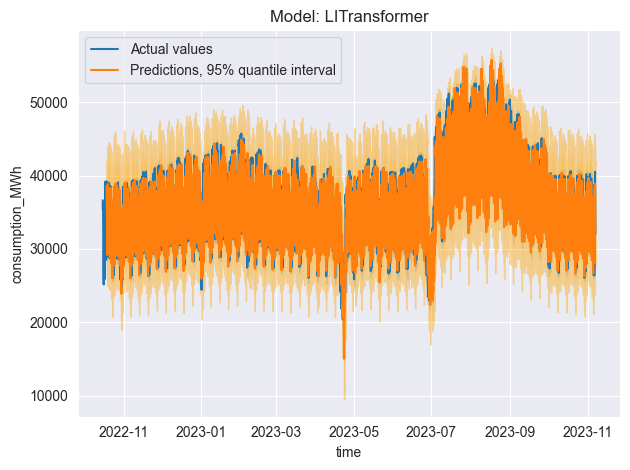

In [55]:
# Predicted vs. actual plot, hourly, entire test period
_ = sns.lineplot(
    data = df_test,
    x = "time",
    y = "consumption_MWh",
    label = "Actual values"
)

_ = sns.lineplot(
    data = df_preds,
    x = "time",
    y = "pred_point",
    label = "Predictions, 95% quantile interval"
)

_ = plt.fill_between(
    x = df_preds.time,
    y1 = df_preds.pred_low,
    y2 = df_preds.pred_high,
    label = "95% prediction interval",
    color = "orange",
    alpha = 0.4
)
_ = plt.title("Model: LITransformer")

In [53]:
def plot_sequence_preds(preds, source_sequences, target_sequences, sequence_index = 0, model = "LITransformer"):

    # Get n. of sequences
    n_sequences = len(target_sequences)
    
    # Get predictions for selected sequence
    preds_low = preds[sequence_index, :, 0]
    preds_point = preds[sequence_index, :, 1]
    preds_high = preds[sequence_index, :, 2]

    # Get & combine actual targets, sources, dates
    date_target = target_sequences[sequence_index].index.to_series()
    target = target_sequences[sequence_index].consumption_MWh.values
    
    date_source = source_sequences[sequence_index].index.to_series()
    source = source_sequences[sequence_index].consumption_lag2.values

    date = pd.concat([date_source, date_target], axis = 0)
    actual = np.concatenate([source, target], axis = 0)

    # Plot
    _ = sns.lineplot(
        x = date,
        y = actual,
        label = "Actual values"
    )

    _ = sns.lineplot(
        x = date_target,
        y = preds_point,
        label = "Predictions, 95% quantile interval"
    )
    
    _ = plt.fill_between(
        x = date_target,
        y1 = preds_low,
        y2 = preds_high,
        color = "orange",
        alpha = 0.4
    )

    _ = plt.title(f"Model: {model},\n Sequence index: {sequence_index} of {n_sequences - 1}")
    _ = plt.xlabel("time")
    _ = plt.ylabel("consumption")

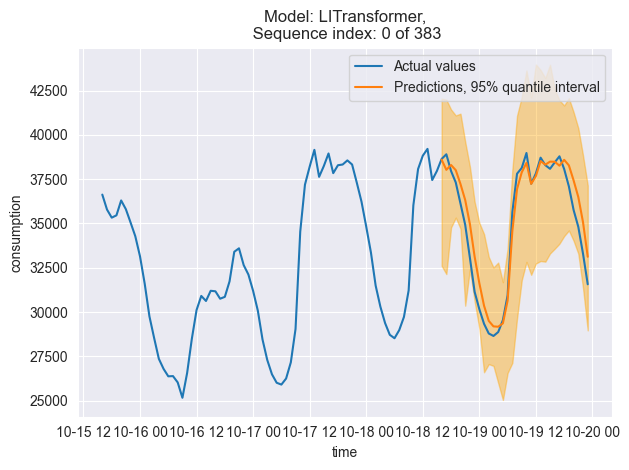

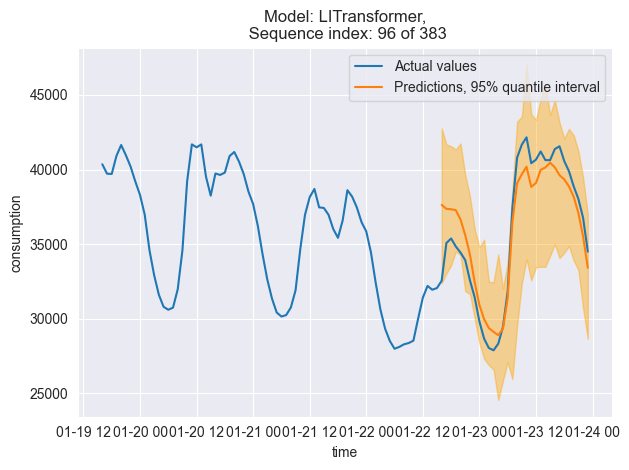

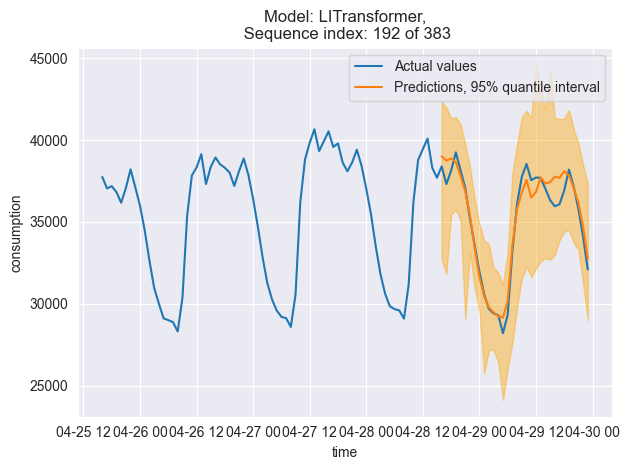

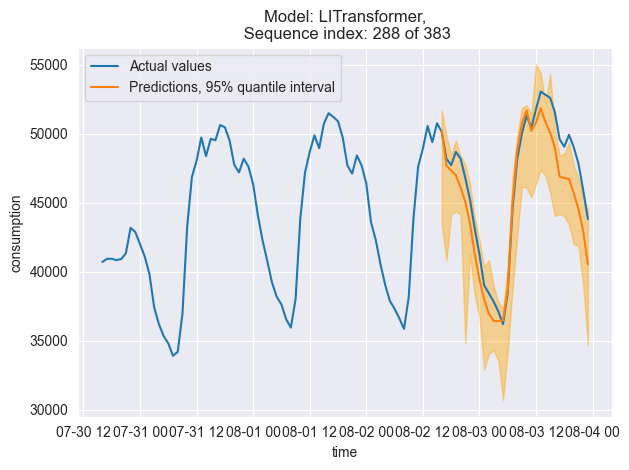

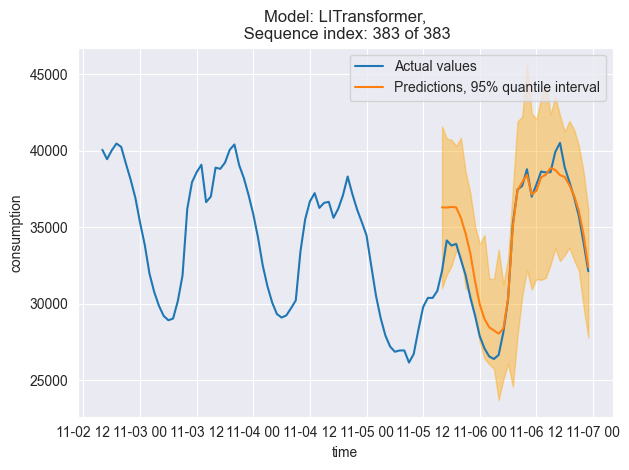

In [54]:
# Predicted vs. actual plots, zoomed in
indices = [i for i in range(0, len(test_target), len(test_target) // 4)]
indices.append(len(test_target) - 1)
for idx in indices:
    plt.figure()
    plot_sequence_preds(preds, test_source, test_target, sequence_index = idx)

In [56]:
# Calculate performance metrics: MAE, RMSLE, MAPE, pinball
rounding = 4
pd.DataFrame([
    mape(df_test_target.consumption_MWh, df_preds.pred_point) * 100,
    rmsle(df_test_target.consumption_MWh, df_preds.pred_point),
    mae(df_test_target.consumption_MWh, df_preds.pred_point),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[0]),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[1]),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[-1])
], columns = ["Model: Inverted quantile Transformer"],
index = [ 
    "MAPE, point", 
    "RMSLE, point",
    "MAE, point",
    f"Pinball loss, q: {quantiles[0] * 100}%",
    f"Pinball loss, q: {quantiles[1] * 100}%",
    f"Pinball loss, q: {quantiles[-1] * 100}%"
]).round(rounding)

,Model: Inverted quantile Transformer
"MAPE, point",3.4677
"RMSLE, point",0.0506
"MAE, point",1265.8440
"Pinball loss, q: 2.5%",584.0679
"Pinball loss, q: 50.0%",632.9220
"Pinball loss, q: 97.5%",681.7762


Keep in mind that for the median quantile, pinball loss equals MAE / 2.